In [1]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('M1_simplified_updated.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] +\
           [masses[link] for link in links] +\
           [lengths[link] for link in links] +\
           [inertias[link] for link in links] +\
           [x_body]+[y_body] + [th[link] for link in links if 'foot' not in link]+[r_prismatic[link] for link in links if 'foot' in link]+\
           [dx_body]+[dy_body] + [dth[link] for link in links if 'foot' not in link]+[dr_prismatic[link] for link in links if 'foot' in link] +\
           [ddx_body]+[ddy_body] + [ddth[link] for link in links if 'foot' not in link]+[ddr_prismatic[link] for link in links if 'foot' in link] +\
           [tau['left']] + [tau['right']] +\
           [fp['left']] + [fp['right']] +\
           [grf['x','left']] + [grf['y','left']] +\
           [grf['x','right']] + [grf['y','right']]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body']

for link in links:
    if 'foot' in link:
        DOFs = DOFs + ['{{r_prismatic}}_{{{0}}}'.format(link)]
    else:
        DOFs = DOFs + ['theta_{0}'.format(link)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>

In [2]:
# PARAMETERS:
masses_ = {'body':2.06,
           'UL': 0.5,
           'UR': 0.5,
           'footL': 0.2,
           'footR': 0.2}

lengths_ = {'body': 24/100,
           'UL': 35.0/100,
           'UR': 35.0/100,
           'footL': 4.0/100,
           'footR': 4.0/100}

''' ****** '''
inertias_ = {'body': (masses_['body']*lengths_['body']**2)/12, # body rotate about its center 
            'UL': (masses_['UL']*lengths_['UL']**2)/12, # rotates as pendulumn ?
            'UR': (masses_['UR']*lengths_['UR']**2)/12,
            'footL': 0.0,
            'footR': 0.0}

In [3]:
WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
links = ['body','UL','UR','footL','footR']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
feet = ['footL','footR']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'UL' ,'right': 'UR'}

total_mass = 0.0
for mass in masses_:
    total_mass += masses_[mass]
total_mass

def get_var_list_zeros(m,n):
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0] +\
               [0.0] + [0.0]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    prismatic_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
        
    for side in sides:
        
#         tau_value.update({(side): \
#         BW*(m.tau_torque[n,'+ve',side]-m.tau_torque[n,'-ve',side])})
        
        tau_value.update({(side): \
        BW*(m.tau_torque[n,side])})
    
        prismatic_force_value.update({(side):\
        BW*(m.Fp[n,side])})
        
    for foot in feet:
        GRF_X_value.update({(foot):BW*(m.GRF_x[n,'+ve',foot]-m.GRF_x[n,'-ve',foot])})
        GRF_Y_value.update({(foot):BW*(m.GRF_y[n,foot])})
    
    var_list = [m.g] +\
               [m.masses[link] for link in links] +\
               [m.lengths[link] for link in links] +\
               [m.inertias[link] for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left']] + [tau_value['right']] +\
               [prismatic_force_value['left']] + [prismatic_force_value['right']] +\
               [GRF_X_value['footL']] + [GRF_Y_value['footL']] +\
               [GRF_X_value['footR']] + [GRF_Y_value['footR']]
    return var_list


<a id='time_step'></a>

In [4]:
tests = {0:"High_Drop_Test",1:"Low_Drop_Test", 2:"Hop_Test", 3:"Drop_Hop_Test",\
         4:"Standing_Test", 5:"Tax_Day_Sprint",6:"Missing_the_Boat",\
         7:"Periodic_Hop",8:"Periodic_Walk"}

test = tests[8]

if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test":
    N = 50
    TT = 0.3
elif test == "Hop_Test" or test == "Drop_Hop_Test":
    N = 50
    TT = 1.0
elif test == "Tax_Day_Sprint":
    N = 50
    TT = 1.5
    x_final = 5.0
elif test == "Missing_the_Boat":
    N = 50
    TT = 1.0
    x_final = 5.0
elif test == "Periodic_Hop":
    N = 50
    TT = 1.0 # 2Hz but only half a gait due to symmetry
    dy_periodic = 0.5
elif test == "Periodic_Walk":
    N = 50
    TT = 0.5 # 2Hz but only half a gait due to symmetry
    dx_periodic = 0.5
    x_final = 1.0 # for display
else:
    N = 50
    TT = 0.5

In [5]:
test

'Periodic_Walk'

In [6]:
m = ConcreteModel('Biped')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.links = Set(initialize = links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)
m.feet = Set(initialize = feet)


#Params--------------------------
m.g = Param(initialize = 9.81)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.links, initialize = masses_)
m.lengths = Param(m.links, initialize = lengths_)
m.inertias = Param(m.links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [7]:
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.5,1.5))

In [8]:
''' CONSTRAINTS  - Integration'''
 
def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [9]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.feet)
for n in range(1,N+1):
    m.foot_position[n,'Y','footL'].setlb(0.0)
    m.foot_position[n,'Y','footR'].setlb(0.0)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,foot): sym.lambdify(sym_list,r_links[foot][coordinates[wdof]],modules = [func_map])}) for foot in feet for wdof in WDOFs]

def def_foot_position(m,n,wdof,foot):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,foot] == lamb_foot_position[wdof,foot](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_position)

m.mu = Param(initialize = 1,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.feet, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.feet, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.feet, bounds = (0.0,None)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.feet, bounds = (0.0,None)) # ground reaction forces

'''******'''
m.ground_penalty = Var(m.N, m.ground_constraints, m.feet, bounds = (0.0,10.0)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(foot): sym.lambdify(sym_list,(r_links[foot].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for foot in feet]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,foot):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',foot]-m.foot_velocity[n,'X','-ve',foot] == lamb_foot_velocity_x[foot](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.feet, rule = def_foot_velocity)

def def_friction_cone(m,n,foot):
    return m.friction_cone[n,foot] == m.mu*m.GRF_y[n,foot] - (m.GRF_x[n,'+ve',foot] + m.GRF_x[n,'-ve',foot])
m.friction_cone_constraint = Constraint(m.N, m.feet, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,foot):
    if n < N:
        return m.foot_position[n+1,'Y',foot]*m.GRF_y[n,foot] <= m.ground_penalty[n,'contact',foot]
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.feet, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,foot):
    return (m.foot_velocity[n,'X','+ve',foot]+m.foot_velocity[n,'X','-ve',foot])*m.friction_cone[n,foot] <= m.ground_penalty[n,'friction',foot]
m.ground_friction_constraint = Constraint(m.N, m.feet, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,foot):
    return m.foot_velocity[n,'X','+ve',foot]*m.GRF_x[n,'+ve',foot] <= m.ground_penalty[n,'slip_+ve',foot]
m.ground_slip_positive_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,foot):
    return m.foot_velocity[n,'X','-ve',foot]*m.GRF_x[n,'-ve',foot] <= m.ground_penalty[n,'slip_-ve',foot]
m.ground_slip_negative_constraint = Constraint(m.N, m.feet, rule = def_ground_slip_negative)

# bound contact forces at last node
for foot in feet:
    m.GRF_y[N,foot].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,foot].fix(0.0)


<a id='constraints'></a>

In [10]:
# Get the foot position in WDOF
if test == "Periodic_Walk" or test == "Periodic_Hop":
    
    lamb_body_position_x = sym.lambdify(sym_list,(r_links['body'])[0].simplify(),modules = [func_map])
    m.body_position = Var(m.N, m.WDOFs) # the sign will account for -ve velocities

    # CONSTRAINTS
    def def_body_position(m,n,wdof):
        var_list = get_var_list_zeros(m,n)
        
        if wdof == 'X':
            return m.body_position[n,'X'] == lamb_body_position_x(*var_list)
        else: return Constraint.Skip
    m.body_position_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position)
    
    # Average velocities
    if test == "Periodic_Walk": pass
#         def def_body_position_average(m,n,wdof):
#             if wdof == 'X':
#                 return (m.body_position[N,'X'] - m.body_position[1,'X'])/TT == dx_periodic
#             else: return Constraint.Skip
#         m.def_body_position_average_constraint = Constraint(m.N, m.WDOFs, rule = def_body_position_average)
        
    else: pass
    
    # Equate states
    
    if test == "Periodic_Walk":
        
        def def_equate_position_states(m,n,dof_i):
            if dof_i == 'x_body': # or dof_i == 'theta_UL' or dof_i == 'theta_UR':
                return Constraint.Skip
            else:
                return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)

        def def_equate_angle_states(m,n):
            return m.q[N,'theta_UL'] == m.q[N,'theta_UR']
        m.def_equate_angle_states_constraint = Constraint(m.N,rule = def_equate_angle_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)
        
    else: 
        
        def def_equate_position_states(m,n,dof_i):
            return m.q[1,dof_i] == m.q[N,dof_i]
        m.def_equate_position_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_position_states)
        
        def def_equate_vel_states(m,n,dof_i):
            return m.dq[1,dof_i] == m.dq[N,dof_i]
        m.def_equate_vel_states_constraint = Constraint(m.N, m.DOFs,rule = def_equate_vel_states)

else: pass
                                    


Text(0, 0.5, 'Torque (Nm)')

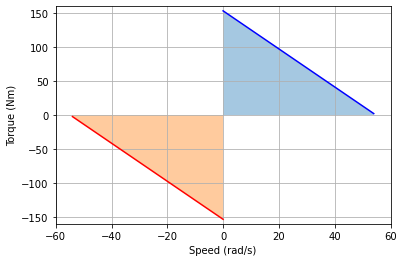

In [11]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
y_p = -2.8*x_p + 153.4
y_n = -2.8*x_n - 153.4

plt.grid()
plt.plot(x_p, y_p,'b')
plt.fill_between(x_p, y_p, alpha=0.4)

plt.plot(x_n, y_n,'r')
plt.fill_between(x_n, y_n, alpha=0.4)

plt.axis((-60,60,-160,160))
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')

In [12]:
# '''Constant Power - Speed Torque Curve'''

# m.tau_torque = Var(m.N, m.signs, m.sides,bounds = (0.0,38.0))
# m.tau_velocity = Var(m.N, m.signs, m.sides,bounds = (0.0,46.0))

# lamb_tau_velocity = {}
# [lamb_tau_velocity.update({(side): sym.lambdify(sym_list,dr_links[motor_w_angle[side]][2],modules = [func_map])}) for side in sides]

# def def_angular_velocity(m,n,side):
#     var_list = get_var_list_zeros(m,n)
#     return m.tau_velocity[n,'+ve',side]-m.tau_velocity[n,'-ve',side] == lamb_tau_velocity[side](*var_list)
# m.left_angular_velocity_constraint = Constraint(m.N, m.sides,rule = def_angular_velocity)

# # assume straight line
# def def_constant_power(m,n,sign,side):
#     if sign == '+ve':
#         return m.tau_torque[n,sign,side] <= m.tau_velocity[n,sign,side]*(-2.8) + 153.4
#     else:
#         return m.tau_torque[n,sign,side] >= m.tau_velocity[n,sign,side]*(-2.8) - 153.4
# m.constant_power = Constraint(m.N, m.signs, m.sides,rule = def_constant_power)

In [13]:
'''Torque Speed - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.sides,bounds = (-38.0,38.0))
m.tau_velocity = Var(m.N, m.sides,bounds = (-46.0,46.0))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side): sym.lambdify(sym_list,dr_links[motor_w_angle[side]][2],modules = [func_map])}) for side in sides]

def def_angular_velocity(m,n,side):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,side] == lamb_tau_velocity[side](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides,rule = def_angular_velocity)

# assume straight line
def def_constant_power_right(m,n,sign,side):
    return m.tau_torque[n,side] <= m.tau_velocity[n,side]*(-2.8) + 153.4
m.constant_power_right_constraint = Constraint(m.N, m.signs, m.sides,rule = def_constant_power_right)

def def_constant_power_left(m,n,sign,side):
    return m.tau_torque[n,side] >= m.tau_velocity[n,side]*(-2.8) - 153.4
m.constant_power_left_constraint = Constraint(m.N, m.signs, m.sides,rule = def_constant_power_left)



In [14]:
m.Fp = Var(m.N, m.sides, bounds = (-50.0,50.0))

In [15]:
''' Use this code for tests '''

# BOUND VALUES
for n in range(1,N+1):
    m.q[n,'theta_body'].setub(np.pi*(1/3))
    m.q[n,'theta_body'].setlb(np.pi*(-1/3))
    
    m.q[n,'{r_prismatic}_{footL}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footL}'].setub(0.35)
    m.q[n,'{r_prismatic}_{footR}'].setlb(0.0)
    m.q[n,'{r_prismatic}_{footR}'].setub(0.35)
    
    m.q[n,'theta_UL'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UL'].setub(np.pi*(1/3))
    m.q[n,'theta_UR'].setlb(np.pi*(-1/3))
    m.q[n,'theta_UR'].setub(np.pi*(1/3))
    
    for foot in feet:
        m.GRF_y[n,foot].setlb(0.0)
        m.GRF_y[n,foot].setub(10*total_mass*m.g.value)
        
        for sgn in signs:
            m.GRF_x[n,sgn,foot].setlb(0.0)
            m.GRF_x[n,sgn,foot].setub(10*total_mass*m.g.value)  
    
    if test == "Periodic_Walk":
        m.q[n,'y_body'].setub(1.0)
        m.dq[1,'y_body'].fix(0.0)
        
    elif test == "Periodic_Hop":
        m.dq[1,'y_body'].fix(0.0)
    
    else:
        for dof in DOFs:
            m.dq[1,dof].fix(0.0)
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test" or test == "Standing_Test" or test == "Drop_Hop_Test" or test =="Periodic_Hop":

        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = -0.5
        y_high_lim = 2.0
        
        
        if test == "Drop_Hop_Test" or "Periodic_Hop":
            #[m.tau_torque[1,sign,side].fix(0.0) for side in sides for sign in signs]
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]
            
        else:
            #[m.tau_torque[n,sign,side].fix(0.0) for side in sides for sign in signs]
            [m.tau_torque[n,side].fix(0.0) for side in sides]
            [m.Fp[n,side].fix(0.0) for side in sides]
        

    else:
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = x_final + 1.0
        y_low_lim = -0.5
        y_high_lim = 1.5
    
        if test == "Periodic_Walk":
            pass
        else:
            #[m.tau_torque[1,sign,side].fix(0.0) for side in sides for sign in signs]
            [m.tau_torque[1,side].fix(0.0) for side in sides]
            [m.Fp[1,side].fix(0.0) for side in sides]

<a id='initial_conditions'></a>

In [16]:
if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.3)
    m.q[1,'y_body'].fix(1.3)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
    m.q[1,'theta_UL'].fix(np.pi*(-2/9))
    m.q[1,'theta_UR'].fix(np.pi*(-2/9))
        
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[1, 'Y', 'footL'].fix(0.2)
    m.foot_position[1, 'Y', 'footR'].fix(0.2)
    
#     m.q[N,'x_body'].setub(0.7)
#     m.q[N,'x_body'].setlb(0.3)

        
# elif test == "Hop_Test":
#     #  ----------------------------- HOP TEST ---------------------------

#     # initial condition
#     m.q[1,'y_body'].fix(0.35)
#     m.q[1,'x_body'].fix(0.0)
#     m.q[1,'theta_body'].fix(np.pi*(0.0))
#     m.foot_position[1, 'Y', 'A'].fix(0.0)
#     m.foot_position[1, 'Y', 'B'].fix(0.0)
#     m.foot_position[1, 'X', 'A'].fix(-0.2)
#     m.foot_position[1, 'X', 'B'].fix(0.2)
        
#     m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'y_body'].fix(1.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(1/6))
    m.q[1,'theta_UR'].fix(np.pi*(1/6))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)
        
    m.foot_position[round(N/5), 'Y', 'footL'].setub(0.05)
    m.foot_position[round(N/5), 'Y', 'footR'].setub(0.05)
    
    m.q[N,'theta_UL'].setub(np.pi*(1/6))
    m.q[N,'theta_UR'].setlb(np.pi*(1/6))
    
    m.q[N,'y_body'].setlb(0.8)
    m.q[N,'x_body'].setub(0.7)
    m.q[N,'x_body'].setlb(0.3)
    
elif test == "Standing_Test":
    
    # initial condition
    m.q[1,'x_body'].fix(0.5)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_UL'].fix(np.pi*(0.5-0.1))
    m.q[1,'theta_UR'].fix(np.pi*(0.5+0.1))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.1)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.1)   
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
     
    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)
    
elif test == 'Tax_Day_Sprint':
    
    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
    guide = np.linspace(0,x_final,N)
    for n in range(1,N+1):
        m.GRF_y[n,'footL'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footL'].value = m.mu.value*m.GRF_y[n,'footL'].value
        m.GRF_y[n,'footR'].value = np.random.uniform(0.0,1)
        m.GRF_x[n,'+ve','footR'].value = m.mu.value*m.GRF_y[n,'footR'].value
        
#         m.q[n,'x'].value = guide[n-1] + np.random.uniform(-0.25,0.25)
#         m.q[n,'y'].value  = np.random.uniform(0.5,1.1)
#         m.q[n,'theta_b'].value  = np.random.uniform(-np.pi/8,np.pi/8)
#         m.q[n,'theta_l'].value  = np.random.uniform(-np.pi/4,np.pi/4)
#         m.q[n,'r'].value  = np.random.uniform(0.0,0.5)
        
    # SPRINT --------------------------------------------------------------------------------------------------------------------
    # tax day

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.0))
    m.q[1,'theta_UR'].fix(np.pi*(0.0))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)

    # final condition
    m.q[N,'x_body'].setlb(x_final)

    m.dq[N,'x_body'].fix(0.0)
    m.dq[N,'theta_body'].fix(0.0)
    m.dq[N,'theta_UL'].fix(0.0)
    m.dq[N,'theta_UR'].fix(0.0)

    m.q[N,'theta_body'].fix(0.0)
    m.q[N,'theta_UL'].fix(np.pi*(0.0))
    m.q[N,'theta_UR'].fix(np.pi*(0.0))

    m.foot_position[N, 'Y', 'footL'].fix(0.0)
    m.foot_position[N, 'Y', 'footR'].fix(0.0)

    #m.pprint()
    
elif test ==  "Missing_the_Boat":
    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(0.0)
    m.q[1,'theta_UL'].fix(np.pi*(0.5))
    m.q[1,'theta_UR'].fix(np.pi*(0.5))
    m.q[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.q[1,'{r_prismatic}_{footR}'].fix(0.0)  
    m.foot_position[1, 'Y', 'footL'].fix(0.0)
    m.foot_position[1, 'Y', 'footR'].fix(0.0)
    m.q[N,'x_body'].setlb(x_final)

elif test == "Periodic_Hop":
    m.q[1,'y_body'].fix(1.0) # initial condition  
    m.q[1,'x_body'].fix(0.0) # initial condition  
    
    m.q[1,'theta_UL'].fix(0.0)
    m.q[1,'theta_UR'].fix(0.0)
    
    m.dq[1,'theta_UL'].fix(0.0)
    m.dq[1,'theta_UR'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footL}'].fix(0.0)
    m.dq[1,'{r_prismatic}_{footR}'].fix(0.0)
    
    m.dq[N,'y_body'].fix(0.0) # initial condition
    

elif test == "Periodic_Walk":
#    # INITIALIZE ----------------------------------------------------------------------------------------------------------------
#     for n in range(1,N+1):
#         m.GRF_y[n,'footL'].value = np.random.uniform(0.0,1)
#         m.GRF_x[n,'+ve','footL'].value = m.mu.value*m.GRF_y[n,'footL'].value
#         m.GRF_y[n,'footR'].value = np.random.uniform(0.0,1)
#         m.GRF_x[n,'+ve','footR'].value = m.mu.value*m.GRF_y[n,'footR'].value
        

    m.q[1,'x_body'].fix(0.0) # initial condition
    m.q[1,'theta_body'].fix(0.0)
    m.q[N,'x_body'].setlb(0.6)
    
else: pass

<a id='cost_function'></a>

In [17]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    # T = sum(m.h[n] for n in range(1,N+1)) # minimum time
    row = 1e4 # scale the penalty
    tau_sum = 0.0
    pen_sum = 0.0
    transport_sum = 0.0
    
    T = sum(m.h[n] for n in range(1,N+1))
    for n in range(1,N+1):
        
            for side in sides:
                #tau_sum += (m.tau_torque[n,'+ve',side]-m.tau_torque[n,'-ve',side])**2
                tau_sum += (m.tau_torque[n,side])**2
                if test == "Periodic_Walk":
                    #transport_sum += ((m.tau_torque[n,'+ve',side]-m.tau_torque[n,'-ve',side])**2)/(m.q[N,'x_body'])
                    transport_sum += ((m.tau_torque[n,side])**2 + (m.Fp[n,side])**2)/(m.q[N,'x_body'])
                else: pass
                
            for gc in ground_constraints:
                for foot in feet:
                    pen_sum += m.ground_penalty[n,gc,foot] 
    if test == "Periodic_Walk":
        return row*pen_sum + transport_sum #+ tau_sum + transport_sum #+ T + tau_sum
    else:
        return row*pen_sum
        
m.Cost = Objective(rule = CostFun)

In [18]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_UL(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UL'](*var_list) == 0
m.EOM_th_UL_constraint = Constraint(m.N, rule = EOM_th_UL)

def EOM_th_UR(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_UR'](*var_list) == 0
m.EOM_th_UR_constraint = Constraint(m.N, rule = EOM_th_UR)

def EOM_r_prismatic_footL(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footL}'](*var_list) == 0
m.EOM_r_prismatic_footL_constraint = Constraint(m.N, rule = EOM_r_prismatic_footL)

def EOM_r_prismatic_footR(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['{r_prismatic}_{footR}'](*var_list) == 0
m.EOM_r_prismatic_footR_constraint = Constraint(m.N, rule = EOM_r_prismatic_footR)

In [19]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000    # maximum number of iterations
opt.options["max_cpu_time"] = 600  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    12245
Number of nonzeros in inequality constraint Jacobian.:     2086
Number of nonzeros in Lagrangian Hessian.............:     5540

Total number of variables............................:     2640
                     variables with only lower bounds:      401
                variables with lower and upper bounds:     1292
                     variables with only upp

  78  6.5926971e+06 1.12e-01 5.71e+02  -1.0 1.22e+01   0.8 5.13e-01 2.64e-01F  1
  79  6.5904444e+06 1.09e-01 1.06e+03  -1.0 1.84e+00   1.2 1.00e+00 2.53e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  6.5499367e+06 1.02e-01 9.49e+02  -1.0 4.50e+00   0.8 2.91e-01 1.20e-01F  1
  81  6.5314932e+06 7.11e-02 5.40e+02  -1.0 9.13e-01   1.2 1.00e+00 3.03e-01f  1
  82  6.4505705e+06 5.35e-02 4.72e+02  -1.0 3.90e+00   0.7 3.48e-01 2.45e-01f  1
  83  6.4422726e+06 4.98e-02 8.14e+02  -1.0 1.03e+00   1.1 1.00e+00 6.83e-02f  1
  84  6.3963041e+06 4.57e-02 7.61e+02  -1.0 4.93e+00   0.7 1.92e-01 8.17e-02f  2
  85  6.3432945e+06 3.07e-02 5.81e+02  -1.0 1.25e+00   1.1 1.00e+00 3.28e-01f  1
  86  6.2875993e+06 2.87e-02 6.73e+02  -1.0 6.39e+00   0.6 1.60e-01 6.30e-02f  2
  87  6.2206308e+06 2.04e-02 7.65e+02  -1.0 1.50e+00   1.0 1.00e+00 2.84e-01f  1
  88  6.1092681e+06 1.87e-02 7.92e+02  -1.0 8.73e+00   0.6 1.02e-01 7.88e-02F  1
  89  6.0600409e+06 1.61e-02

 171  1.0936428e+06 7.33e-04 1.06e+02  -1.0 2.13e+00   0.7 1.95e-01 1.45e-01f  1
 172  1.0308925e+06 3.99e-02 1.11e+03  -1.0 5.56e+00   0.2 2.64e-01 6.69e-01f  1
 173  1.0300103e+06 3.89e-02 6.76e+02  -1.0 1.92e+00   0.7 6.01e-01 2.36e-02f  1
 174  1.0250081e+06 3.68e-02 5.51e+02  -1.0 6.08e+00   0.2 9.06e-03 5.97e-02f  1
 175  1.0231567e+06 3.43e-02 9.80e+02  -1.0 2.25e+00   0.6 7.67e-01 6.62e-02f  1
 176  1.0176968e+06 7.47e-03 5.04e+02  -1.0 1.17e+00   1.0 1.00e+00 4.58e-01f  1
 177  1.0118468e+06 2.36e-03 9.18e+00  -1.0 3.24e-01   1.5 1.00e+00 1.00e+00f  1
 178  1.0102049e+06 1.65e-05 9.42e+00  -1.0 1.25e-01   1.9 1.00e+00 1.00e+00f  1
 179  1.0069404e+06 7.71e-05 9.15e+01  -1.0 3.70e-01   1.4 1.00e+00 7.45e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  9.9544818e+05 9.08e-04 8.41e+00  -1.0 1.00e+00   0.9 1.00e+00 1.00e+00f  1
 181  9.7138175e+05 6.89e-03 6.65e+02  -1.0 2.91e+00   0.4 1.00e+00 7.07e-01f  1
 182  9.5765067e+05 1.23e-03

 265  8.2174554e+04 1.45e-01 4.87e+01  -1.7 5.73e+00  -0.8 2.33e-01 2.71e-01f  1
 266  8.2099547e+04 1.39e-01 6.01e+01  -1.7 1.86e+00  -0.4 9.68e-02 4.41e-02f  1
 267  8.0480927e+04 1.07e-01 4.86e+02  -1.7 5.05e+00  -0.8 1.57e-02 2.21e-01f  1
 268  8.0032778e+04 1.04e-01 1.66e+02  -1.7 2.59e+01  -1.3 9.91e-02 2.25e-02f  1
 269  7.6015809e+04 4.51e-02 2.07e+02  -1.7 5.72e+00  -0.9 5.95e-01 5.14e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  7.5018192e+04 4.24e-02 1.48e+02  -1.7 2.05e+01  -1.4 1.66e-02 5.44e-02f  1
 271  7.5015819e+04 4.22e-02 6.90e+02  -1.7 1.69e+00   0.9 1.22e-01 4.17e-03h  1
 272  7.4985382e+04 3.78e-02 2.09e+03  -1.7 4.75e-01   0.4 1.00e+00 1.02e-01f  1
 273  7.4016142e+04 2.28e-03 4.11e+02  -1.7 8.59e-01  -0.1 3.49e-01 9.10e-01f  1
 274  7.3856382e+04 1.43e-03 2.54e+02  -1.7 3.11e-01   0.3 5.89e-01 3.85e-01f  1
 275  7.2988207e+04 1.22e-03 4.24e+01  -1.7 9.54e-01  -0.2 6.64e-01 7.12e-01f  1
 276  7.0797981e+04 5.84e-03

 358  1.3938450e+04 1.23e-04 3.13e+01  -3.8 1.56e-01  -0.9 2.05e-02 6.90e-02f  1
 359  1.3938452e+04 1.23e-04 3.13e+01  -3.8 5.30e-01  -0.5 2.83e-04 1.06e-03f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  1.3938455e+04 1.23e-04 4.83e+01  -3.8 1.18e+00  -0.1 3.14e-02 1.05e-03h  1
 361  1.3937377e+04 5.65e-05 3.58e+01  -3.8 5.71e-02  -0.5 3.07e-01 5.50e-01f  1
 362  1.3936726e+04 1.60e-06 1.78e+02  -3.8 2.19e-02  -0.1 3.16e-01 9.83e-01f  1
 363  1.3936203e+04 1.88e-06 1.38e+02  -3.8 6.82e-02  -0.6 3.07e-01 2.31e-01f  1
 364  1.3935737e+04 2.35e-06 1.37e+02  -3.8 3.20e-01  -1.1 4.77e-01 4.98e-02f  1
 365  1.3929652e+04 8.19e-05 8.81e+01  -3.8 5.62e-01  -1.5 1.37e-01 3.40e-01f  1
 366  1.3914197e+04 3.20e-04 5.96e+01  -3.8 1.53e+00  -2.0 4.94e-01 3.47e-01f  1
 367  1.3866308e+04 3.32e-03 2.99e+01  -3.8 4.21e+00  -2.5 2.03e-01 4.52e-01f  1
 368  1.3840908e+04 3.81e-03 2.71e+01  -3.8 1.03e+01  -3.0 1.60e-01 1.12e-01f  1
 369  1.3840580e+04 3.32e-03

 453  1.2633481e+04 1.44e-03 4.28e+01  -3.8 8.21e-02  -1.1 1.00e+00 4.56e-01f  1
 454  1.2632052e+04 6.60e-05 1.51e+01  -3.8 1.16e-01  -1.6 7.30e-01 1.00e+00f  1
 455  1.2631443e+04 4.02e-05 1.67e+01  -3.8 3.98e-01  -2.0 1.00e+00 3.95e-01h  1
 456  1.2627613e+04 9.70e-05 1.03e+01  -3.8 1.13e+00  -2.5 4.31e-01 1.00e+00f  1
 457  1.2624185e+04 1.70e-04 3.35e+01  -3.8 3.08e+00  -3.0 1.00e+00 3.00e-01f  1
 458  1.2617589e+04 3.79e-04 2.91e+01  -3.8 6.99e+00  -3.5 3.09e-01 2.23e-01f  1
 459  1.2597969e+04 1.92e-03 5.11e+01  -3.8 1.97e+01  -4.0 5.72e-01 2.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  1.2579790e+04 1.15e-02 3.97e+01  -3.8 7.63e+01  -4.4 1.77e-02 8.63e-02f  1
 461  1.2533672e+04 2.65e-02 3.31e+01  -3.8 2.22e+01  -4.0 4.36e-01 5.66e-01f  1
 462  1.2532876e+04 2.67e-02 2.86e+01  -3.8 1.60e+04  -4.5 6.91e-05 4.55e-05f  1
 463  1.2527983e+04 5.33e-02 1.25e+02  -3.8 1.05e+03  -5.0 2.23e-03 1.07e-02f  1
 464  1.2523259e+04 5.37e-02

 546  1.2123141e+04 1.66e-07 8.54e+02  -3.8 3.45e+00  -1.2 3.11e-01 4.32e-03f  2
 547  1.2123090e+04 1.62e-07 7.02e+02  -3.8 3.99e-01  -1.7 1.76e-01 2.44e-02h  2
 548  1.2122191e+04 7.46e-06 5.33e+02  -3.8 1.44e+00  -2.2 2.43e-01 1.59e-01f  1
 549  1.2119004e+04 1.16e-04 4.95e+02  -3.8 5.94e+00  -2.6 5.54e-02 1.52e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 550  1.2113889e+04 3.78e-04 2.31e+02  -3.8 1.45e+01  -3.1 6.19e-01 1.05e-01f  1
 551  1.2095926e+04 4.06e-03 2.02e+02  -3.8 3.70e+01  -3.6 8.53e-02 1.59e-01f  1
 552  1.2076073e+04 8.45e-03 2.14e+02  -3.8 1.27e+01  -4.1 2.68e-01 4.94e-01f  1
 553  1.2060535e+04 8.10e-03 9.82e+01  -3.8 3.71e+01  -4.6 3.95e-01 1.75e-01f  1
 554  1.2019956e+04 6.68e-03 8.82e+01  -3.8 9.87e+01  -5.0 1.63e-01 2.16e-01f  1
 555  1.2019568e+04 6.68e-03 3.47e+02  -3.8 9.17e+02  -5.5 4.15e-02 8.10e-04h  1
 556  1.2006259e+04 6.60e-03 2.41e+02  -3.8 2.51e+03  -6.0 3.15e-03 1.51e-02f  1
 557  1.2006263e+04 6.42e-03

 641  1.1645385e+04 8.23e-03 2.21e+02  -3.8 2.38e+02  -5.5 1.54e-01 7.76e-02f  1
 642  1.1624322e+04 5.47e-03 1.22e+02  -3.8 9.13e+01  -5.1 1.98e-01 3.22e-01f  1
 643  1.1603617e+04 7.73e-03 2.92e+02  -3.8 2.39e+02  -5.6 3.35e-01 1.34e-01f  1
 644  1.1593347e+04 2.26e-03 1.76e+02  -3.8 1.28e+01  -4.2 2.23e-01 1.00e+00h  1
 645  1.1576631e+04 2.83e-03 5.92e+01  -3.8 3.95e+01  -4.7 1.00e+00 6.38e-01f  1
 646  1.1559835e+04 4.51e-03 4.64e+01  -3.8 1.10e+02  -5.2 2.83e-01 2.56e-01f  1
 647  1.1539601e+04 8.44e-03 5.55e+01  -3.8 2.81e+02  -5.7 3.87e-02 1.26e-01f  1
 648  1.1516961e+04 1.66e-02 1.21e+02  -3.8 5.87e+02  -6.1 6.70e-02 9.21e-02f  1
 649  1.1513800e+04 1.43e-02 9.13e+01  -3.8 4.32e+01  -4.8 1.00e+00 1.43e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 650  1.1479747e+04 1.80e-02 4.58e+01  -3.8 1.10e+02  -5.3 3.92e-01 7.45e-01h  1
 651  1.1459827e+04 2.35e-02 1.39e+01  -3.8 2.47e+02  -5.8 2.36e-01 2.06e-01f  1
 652  1.1436777e+04 3.69e-02

 735  1.1293546e+04 7.56e-06 1.07e+03  -5.7 1.79e-01  -2.4 9.52e-01 3.78e-01f  1
 736  1.1293442e+04 5.28e-06 7.67e+02  -5.7 9.13e-03  -1.1 9.96e-01 3.02e-01f  1
 737  1.1293353e+04 3.38e-06 4.90e+02  -5.7 3.05e-02  -1.5 3.10e-01 3.61e-01f  1
 738  1.1293318e+04 2.78e-06 4.03e+02  -5.7 1.02e-01  -2.0 3.37e-01 1.78e-01f  1
 739  1.1293269e+04 2.22e-06 3.18e+02  -5.7 2.62e-01  -2.5 1.06e-01 2.10e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 740  1.1293209e+04 2.42e-06 2.71e+02  -5.7 7.88e-01  -3.0 3.69e-01 1.51e-01f  1
 741  1.1293209e+04 2.37e-06 2.65e+02  -5.7 1.63e-02   1.1 6.92e-03 2.29e-02f  2
 742  1.1293207e+04 2.33e-06 2.62e+02  -5.7 1.55e-02   1.5 6.94e-02 1.52e-02h  1
 743  1.1293138e+04 1.66e-07 1.92e+01  -5.7 1.88e-04   1.0 1.00e+00 9.29e-01f  1
 744  1.1293132e+04 9.97e-09 7.32e-04  -5.7 2.13e-04   0.5 1.00e+00 1.00e+00f  1
 745  1.1293131e+04 9.97e-09 7.31e-04  -5.7 6.39e-04   0.1 1.00e+00 1.00e+00h  1
 746  1.1293130e+04 9.97e-09

 829  1.1104975e+04 2.76e-01 1.27e+02  -5.7 1.76e+02    -  3.39e-02 2.25e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 830  1.1103443e+04 2.36e-01 1.08e+02  -5.7 1.37e+02    -  1.98e-01 1.44e-01h  1
 831  1.1102691e+04 2.15e-01 9.63e+01  -5.7 1.18e+02    -  2.61e-01 9.12e-02h  1
 832  1.1100875e+04 1.54e-01 7.02e+01  -5.7 1.58e+02    -  2.17e-01 2.84e-01h  1
 833  1.1100767e+04 1.42e-01 9.74e+01  -5.7 1.93e+00  -4.6 1.00e+00 7.26e-02h  1
 834  1.1100549e+04 1.18e-01 8.19e+01  -5.7 2.26e-01  -2.4 5.80e-01 1.68e-01h  1
 835  1.1100495e+04 1.15e-01 7.97e+01  -5.7 2.13e+00  -2.0 3.01e-02 2.69e-02h  1
 836  1.1100431e+04 1.08e-01 9.58e+01  -5.7 1.43e-01   0.2 5.18e-03 6.14e-02h  1
 837  1.1100430e+04 1.08e-01 9.58e+01  -5.7 1.07e-01   2.5 8.89e-03 1.55e-03h  1
 838  1.1100425e+04 1.07e-01 9.45e+01  -5.7 1.29e-01   2.0 4.84e-03 1.21e-02h  1
 839  1.1100422e+04 1.06e-01 9.39e+01  -5.7 1.28e-01   1.5 1.52e-02 7.90e-03h  1
iter    objective    inf_pr 

 922  1.1096272e+04 1.00e-08 3.58e-02  -7.0 2.18e-02  -5.2 1.00e+00 1.00e+00h  1
 923  1.1096272e+04 1.00e-08 2.11e-01  -7.0 7.42e-02  -5.7 1.00e+00 1.00e+00h  1
 924  1.1096272e+04 1.00e-08 5.11e-02  -7.0 2.49e-02  -5.3 1.00e+00 1.00e+00h  1
 925  1.1096272e+04 1.00e-08 3.11e-01  -7.0 8.88e-02  -5.7 1.00e+00 1.00e+00h  1
 926  1.1096272e+04 1.00e-08 7.24e-02  -7.0 2.99e-02  -5.3 1.00e+00 1.00e+00h  1
 927  1.1096272e+04 1.00e-08 3.95e-01  -7.0 1.01e-01  -5.8 1.00e+00 1.00e+00h  1
 928  1.1096272e+04 1.00e-08 8.75e-02  -7.0 3.35e-02  -5.4 1.00e+00 1.00e+00h  1
 929  1.1096272e+04 1.00e-08 5.30e-01  -7.0 1.19e-01  -5.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 930  1.1096272e+04 1.00e-08 1.16e-01  -7.0 3.83e-02  -5.4 1.00e+00 1.00e+00h  1
 931  1.1096272e+04 1.00e-08 6.06e-01  -7.0 1.35e-01  -5.9 1.00e+00 1.00e+00h  1
 932  1.1096272e+04 1.00e-08 1.16e-01  -7.0 4.04e-02  -5.5 1.00e+00 1.00e+00h  1
 933  1.1096272e+04 1.00e-08

In [20]:
print(results.solver.termination_condition) # check if optimal

optimal


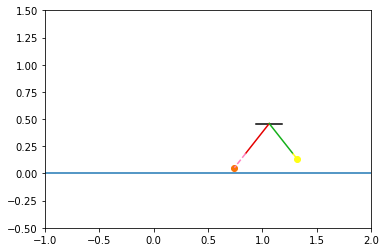

In [21]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_UL = {}
    plot_UR = {}
    plot_footL = {}
    plot_footR = {}
    abs_angles = {}
    
    # plot boom
    #ax.plot(m.boom_position[i,'X'].value, m.boom_position[i,'Y'].value, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="black")

    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')

    link_colour = ['red','pink','purple','green','yellow','orange']
    
    #plot upper left
    abs_angles.update({('UL'): -m.q[i,'theta_body'].value + m.q[i,'theta_UL'].value})
    plot_UL.update({('top','X'): m.q[i,'x_body'].value})
    plot_UL.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UL.update({('bot','X'): m.q[i,'x_body'].value - m.lengths['UL']*sin(abs_angles['UL'])})
    plot_UL.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UL']*cos(abs_angles['UL'])})
    ax.plot([plot_UL['top','X'],plot_UL['bot','X']],[plot_UL['top','Y'],plot_UL['bot','Y']],color='xkcd:{0}'.format(link_colour[0]))


    #plot upper right
    abs_angles.update({('UR'): m.q[i,'theta_body'].value + m.q[i,'theta_UR'].value})
    plot_UR.update({('top','X'): m.q[i,'x_body'].value})
    plot_UR.update({('top','Y'): m.q[i,'y_body'].value})
    plot_UR.update({('bot','X'): m.q[i,'x_body'].value + m.lengths['UR']*sin(abs_angles['UR'])})
    plot_UR.update({('bot','Y'): m.q[i,'y_body'].value - m.lengths['UR']*cos(abs_angles['UR'])})
    ax.plot([plot_UR['top','X'],plot_UR['bot','X']],[plot_UR['top','Y'],plot_UR['bot','Y']],color='xkcd:{0}'.format(link_colour[3]))
    
    #plot left foot
    plot_footL.update({('bot','X'): m.q[i,'x_body'].value - (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*sin(abs_angles['UL'])})
    plot_footL.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UL']+m.q[i,'{r_prismatic}_{footL}'].value)*cos(abs_angles['UL'])})
    ax.plot(plot_footL['bot','X'],plot_footL['bot','Y'],color='xkcd:{0}'.format(link_colour[5]), marker='o')

    #plot right foot
    plot_footR.update({('bot','X'): m.q[i,'x_body'].value + (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*sin(abs_angles['UR'])})
    plot_footR.update({('bot','Y'): m.q[i,'y_body'].value - (m.lengths['UR']+m.q[i,'{r_prismatic}_{footR}'].value)*cos(abs_angles['UR'])})
    ax.plot(plot_footR['bot','X'],plot_footR['bot','Y'],color='xkcd:{0}'.format(link_colour[4]), marker='o')
    
    # virtual prismatic links
    ax.plot([plot_UL['bot','X'],plot_footL['bot','X']],[plot_UL['bot','Y'],plot_footL['bot','Y']],color='xkcd:{0}'.format(link_colour[1]),ls='--')
    ax.plot([plot_UR['bot','X'],plot_footR['bot','X']],[plot_UR['bot','Y'],plot_footR['bot','Y']],color='xkcd:{0}'.format(link_colour[4]),ls='--')
    
    ax.plot([-10,10],[0,0]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [22]:
print(results.solver.termination_condition) # check if optimal

optimal


In [23]:
f = r"{0}.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo) 
len(N_time)

102

In [24]:
vel = 0.0

for n in range(1,N+1):
    #print(m.ddq[n,'y_body'].value)
    #print(m.q[n,'{r_prismatic}_{footL}'].value)
    #print(m.foot_position[n, 'Y', 'footR'].value)
    #print(m.q[n,'y_body'].value)
#     print(m.dq[n,'x_body'].value)
#     vel = vel + m.dq[n,'x_body'].value
    print(m.GRF_y[n,'footL'].value+m.GRF_y[n,'footR'].value)
    
vel/TT

-1.4065755463447853e-08
-1.4053968374376656e-08
-1.4064365763593581e-08
-1.406558488143893e-08
-1.4064306149868611e-08
-1.4061805444776112e-08
3.827247797661711e-09
6.7139742577175015e-09
2.197732315142689e-08
9.131346116340632e-08
8.577129520938942e-07
14.68796320613587
22.037041455312938
22.008447077296786
5.116271289764277
10.837899091884442
12.291269276532775
13.901675071381183
82.33655575713507
23.259794839198936
42.508995628368936
41.26625131941755
45.66254585147673
50.34543485335407
54.963101922646935
58.97237818904637
59.6086467396881
63.21519774173091
65.80306159527547
67.17835429517191
67.30939079341726
75.38946104088305
81.1329272316213
83.82161642799574
82.9965098898619
78.71626134204153
71.65102067113114
62.22569407682891
30.84352346617568
31.05578151113935
30.331728281081432
1.8010633910846188e-07
7.089774794394573e-08
1.6878305302594992e-08
3.824320704160511e-09
-1.3964590135305835e-08
-1.4006077150927225e-08
-1.4044839076943564e-08
-1.4045357936083088e-08
0.0


0.0

In [25]:
tau_sum_value = 0.0
pen_sum_value = 0.0
transport_sum_value = 0.0

for n in range(1,N+1):

        for side in sides:
            tau_sum_value += (m.tau_torque[n,'+ve',side].value-m.tau_torque[n,'-ve',side].value)**2 
        transport_sum_value += ((m.tau_torque[n,'+ve','right'].value-m.tau_torque[n,'-ve','right'].value + m.tau_torque[n,'+ve','left'].value-m.tau_torque[n,'-ve','left'].value)**2)/(m.q[N,'x_body'].value)

        for gc in ground_constraints:
            for foot in feet:
                pen_sum_value += m.ground_penalty[n,gc,foot].value 
                
print(pen_sum_value*(10**4))
print(transport_sum_value)

KeyError: "Index '(1, '+ve', 'left')' is not valid for indexed component 'tau_torque'"

In [ ]:
print(results.solver.termination_condition) # check if optimal

<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>

<a href='#cost_function'>Link to cost function'</a>

<a href='#constraints'>Link to constraints'</a>